<a href="https://colab.research.google.com/github/YeonJaeHong/ESAA_homeworks/blob/main/10_30_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 파이썬 머신러닝
ch4. 8~9 pg. 252~277
08. 분류 실습- 캐글 산탄데르 고객 만족 예측

고객 만족 여부를 XGBOOST 와 lightGBM을 활용해 예측

 > Santander Customer Satisfaction
*   370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것
*   클래스 레이블 명은 TARGET 이며 이 값이 1이면 불만을 가진 고객, 0이면 만족한고객
>>모델의 성능 평가는 ROC-AUC로 평가진행(대부분이 만족이고 일부가 불만족일것이기에 정확도 수치보다 곡선이 더 ROC 곡선 영역이 더 정확)


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df= pd.read_csv("/content/train_santander.csv",encoding='latin-1')
print('dataset shape:',cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [23]:
#클래스 값 칼럼을 포함한 피처 371개 존재, 피처 타입과 Null값을 알아봐야함
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [8]:
#111개의 피처가 float 형, 260개의 피처가 int 형으로 모든 피처가 숫자형이며, Null 값은 없다.
#전체 데이터에서 만족과 불만족의 비율은 레이블인 target 속성의 값의 분포를 알아보면된다

print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))


0.0    23178
1.0      995
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [24]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
#var3 min 값이 -9999999  은 편차가 너무 심하다 아마 Nan이나 특정 예외를 이렇게 표시했을것이다
# var3 에는 이 값이 116개가 있고 (value_count로 확인하면) 이는 편차가 너무 심함으로 최빈값인 2로 변환

In [25]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop("ID", axis=1, inplace=True)

#피처 세트와 레이블 세트 분리, 레이블 칼럼은 dataframe의 맨 마지막에 위치해 칼럼위치 -1로 분리
X_features= cust_df.iloc[:,:-1]
y_labels= cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape,X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


xgboost 모델 학습과 하이퍼 파라미터 튜닝

xgboost 학습 모델을 생성하고 예측결과를 rocauc로 평가
  



In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83789	validation_1-auc:0.82554
[1]	validation_0-auc:0.84273	validation_1-auc:0.82878
[2]	validation_0-auc:0.84901	validation_1-auc:0.83359
[3]	validation_0-auc:0.85530	validation_1-auc:0.83767
[4]	validation_0-auc:0.85891	validation_1-auc:0.83909
[5]	validation_0-auc:0.86117	validation_1-auc:0.84156
[6]	validation_0-auc:0.86378	validation_1-auc:0.84138
[7]	validation_0-auc:0.86737	validation_1-auc:0.84048
[8]	validation_0-auc:0.87021	validation_1-auc:0.84162
[9]	validation_0-auc:0.87258	validation_1-auc:0.84100
[10]	validation_0-auc:0.87505	validation_1-auc:0.84117
[11]	validation_0-auc:0.87747	validation_1-auc:0.84111
[12]	validation_0-auc:0.87872	validation_1-auc:0.84114
[13]	validation_0-auc:0.88087	validation_1-auc:0.84066
[14]	validation_0-auc:0.88208	validation_1-auc:0.84014
[15]	validation_0-auc:0.88340	validation_1-auc:0.83965
[16]	validation_0-auc:0.88557	validation_1-auc:0.83950
[17]	validation_0-auc:0.88664	validation_1-auc:0.84013
[18]	validation_0-au

In [30]:

from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree': [0.5, 0.75]}

# cv 는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80705	validation_1-auc:0.80366
[1]	validation_0-auc:0.80607	validation_1-auc:0.80683
[2]	validation_0-auc:0.79962	validation_1-auc:0.80156
[3]	validation_0-auc:0.80463	validation_1-auc:0.80839
[4]	validation_0-auc:0.82994	validation_1-auc:0.82595
[5]	validation_0-auc:0.84026	validation_1-auc:0.83143
[6]	validation_0-auc:0.84642	validation_1-auc:0.83616
[7]	validation_0-auc:0.84635	validation_1-auc:0.83399
[8]	validation_0-auc:0.85018	validation_1-auc:0.83592
[9]	validation_0-auc:0.85084	validation_1-auc:0.83463
[10]	validation_0-auc:0.85227	validation_1-auc:0.83362
[11]	validation_0-auc:0.85527	validation_1-auc:0.83695
[12]	validation_0-auc:0.85693	validation_1-auc:0.83944
[13]	validation_0-auc:0.85857	validation_1-auc:0.83941
[14]	validation_0-auc:0.85898	validation_1-auc:0.83988
[15]	validation_0-auc:0.85928	validation_1-auc:0.83954
[16]	validation_0-auc:0.86102	validation_1-auc:0.83887
[17]	validation_0-auc:0.86239	validation_1-auc:0.83818
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81228	validation_1-auc:0.81007
[1]	validation_0-auc:0.81372	validation_1-auc:0.81399
[2]	validation_0-auc:0.81224	validation_1-auc:0.81337
[3]	validation_0-auc:0.80969	validation_1-auc:0.81042
[4]	validation_0-auc:0.83233	validation_1-auc:0.82795
[5]	validation_0-auc:0.84134	validation_1-auc:0.83396
[6]	validation_0-auc:0.84647	validation_1-auc:0.83741
[7]	validation_0-auc:0.84709	validation_1-auc:0.83382
[8]	validation_0-auc:0.85138	validation_1-auc:0.83695
[9]	validation_0-auc:0.85288	validation_1-auc:0.83754
[10]	validation_0-auc:0.85382	validation_1-auc:0.83662
[11]	validation_0-auc:0.85712	validation_1-auc:0.83727
[12]	validation_0-auc:0.85973	validation_1-auc:0.83969
[13]	validation_0-auc:0.86116	validation_1-auc:0.83962
[14]	validation_0-auc:0.86171	validation_1-auc:0.83988
[15]	validation_0-auc:0.86220	validation_1-auc:0.84080
[16]	validation_0-auc:0.86308	validation_1-auc:0.84160
[17]	validation_0-auc:0.86402	validation_1-auc:0.84149
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81466	validation_1-auc:0.81285
[1]	validation_0-auc:0.81725	validation_1-auc:0.81316
[2]	validation_0-auc:0.81285	validation_1-auc:0.81249
[3]	validation_0-auc:0.81026	validation_1-auc:0.80728
[4]	validation_0-auc:0.83250	validation_1-auc:0.82776
[5]	validation_0-auc:0.84146	validation_1-auc:0.83464
[6]	validation_0-auc:0.84638	validation_1-auc:0.83710
[7]	validation_0-auc:0.84626	validation_1-auc:0.83706
[8]	validation_0-auc:0.84956	validation_1-auc:0.83959
[9]	validation_0-auc:0.85123	validation_1-auc:0.83785
[10]	validation_0-auc:0.85238	validation_1-auc:0.83855
[11]	validation_0-auc:0.85550	validation_1-auc:0.84113
[12]	validation_0-auc:0.85812	validation_1-auc:0.84284
[13]	validation_0-auc:0.85982	validation_1-auc:0.84394
[14]	validation_0-auc:0.86123	validation_1-auc:0.84418
[15]	validation_0-auc:0.86146	validation_1-auc:0.84381
[16]	validation_0-auc:0.86247	validation_1-auc:0.84414
[17]	validation_0-auc:0.86327	validation_1-auc:0.84468
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80747	validation_1-auc:0.80466
[1]	validation_0-auc:0.80852	validation_1-auc:0.81085
[2]	validation_0-auc:0.80504	validation_1-auc:0.81057
[3]	validation_0-auc:0.80266	validation_1-auc:0.80764
[4]	validation_0-auc:0.82807	validation_1-auc:0.82809
[5]	validation_0-auc:0.83836	validation_1-auc:0.83554
[6]	validation_0-auc:0.84477	validation_1-auc:0.83803
[7]	validation_0-auc:0.84419	validation_1-auc:0.83596
[8]	validation_0-auc:0.84799	validation_1-auc:0.83803
[9]	validation_0-auc:0.84906	validation_1-auc:0.83753
[10]	validation_0-auc:0.84971	validation_1-auc:0.83694
[11]	validation_0-auc:0.85365	validation_1-auc:0.83926
[12]	validation_0-auc:0.85517	validation_1-auc:0.84004
[13]	validation_0-auc:0.85619	validation_1-auc:0.84024
[14]	validation_0-auc:0.85662	validation_1-auc:0.83998
[15]	validation_0-auc:0.85692	validation_1-auc:0.84008
[16]	validation_0-auc:0.85798	validation_1-auc:0.84006
[17]	validation_0-auc:0.85883	validation_1-auc:0.83951
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81220	validation_1-auc:0.81035
[1]	validation_0-auc:0.81620	validation_1-auc:0.81399
[2]	validation_0-auc:0.81114	validation_1-auc:0.81153
[3]	validation_0-auc:0.80859	validation_1-auc:0.81108
[4]	validation_0-auc:0.83174	validation_1-auc:0.82898
[5]	validation_0-auc:0.84000	validation_1-auc:0.83470
[6]	validation_0-auc:0.84578	validation_1-auc:0.83755
[7]	validation_0-auc:0.84621	validation_1-auc:0.83739
[8]	validation_0-auc:0.85150	validation_1-auc:0.83922
[9]	validation_0-auc:0.85156	validation_1-auc:0.83773
[10]	validation_0-auc:0.85210	validation_1-auc:0.83796
[11]	validation_0-auc:0.85483	validation_1-auc:0.83951
[12]	validation_0-auc:0.85710	validation_1-auc:0.84083
[13]	validation_0-auc:0.85796	validation_1-auc:0.84144
[14]	validation_0-auc:0.85921	validation_1-auc:0.84061
[15]	validation_0-auc:0.85977	validation_1-auc:0.84036
[16]	validation_0-auc:0.86037	validation_1-auc:0.84097
[17]	validation_0-auc:0.86083	validation_1-auc:0.83991
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81628	validation_1-auc:0.81528
[1]	validation_0-auc:0.81766	validation_1-auc:0.81405
[2]	validation_0-auc:0.81056	validation_1-auc:0.80907
[3]	validation_0-auc:0.80837	validation_1-auc:0.80751
[4]	validation_0-auc:0.83299	validation_1-auc:0.82759
[5]	validation_0-auc:0.84038	validation_1-auc:0.83310
[6]	validation_0-auc:0.84519	validation_1-auc:0.83707
[7]	validation_0-auc:0.84510	validation_1-auc:0.83735
[8]	validation_0-auc:0.84914	validation_1-auc:0.83931
[9]	validation_0-auc:0.85000	validation_1-auc:0.83781
[10]	validation_0-auc:0.85037	validation_1-auc:0.83743
[11]	validation_0-auc:0.85386	validation_1-auc:0.83843
[12]	validation_0-auc:0.85604	validation_1-auc:0.84028
[13]	validation_0-auc:0.85739	validation_1-auc:0.84073
[14]	validation_0-auc:0.85779	validation_1-auc:0.84056
[15]	validation_0-auc:0.85825	validation_1-auc:0.84085
[16]	validation_0-auc:0.85922	validation_1-auc:0.84027
[17]	validation_0-auc:0.86035	validation_1-auc:0.84135
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82532	validation_1-auc:0.81824
[1]	validation_0-auc:0.82615	validation_1-auc:0.81742
[2]	validation_0-auc:0.82345	validation_1-auc:0.81106
[3]	validation_0-auc:0.82145	validation_1-auc:0.80928
[4]	validation_0-auc:0.84325	validation_1-auc:0.82826
[5]	validation_0-auc:0.85394	validation_1-auc:0.83492
[6]	validation_0-auc:0.86149	validation_1-auc:0.83770
[7]	validation_0-auc:0.86164	validation_1-auc:0.83708
[8]	validation_0-auc:0.86700	validation_1-auc:0.83847
[9]	validation_0-auc:0.86883	validation_1-auc:0.83713
[10]	validation_0-auc:0.86999	validation_1-auc:0.83555
[11]	validation_0-auc:0.87388	validation_1-auc:0.83734
[12]	validation_0-auc:0.87607	validation_1-auc:0.83860
[13]	validation_0-auc:0.87761	validation_1-auc:0.83849
[14]	validation_0-auc:0.87769	validation_1-auc:0.83739
[15]	validation_0-auc:0.87822	validation_1-auc:0.83749
[16]	validation_0-auc:0.87940	validation_1-auc:0.83660
[17]	validation_0-auc:0.88086	validation_1-auc:0.83734
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83249	validation_1-auc:0.81755
[1]	validation_0-auc:0.83199	validation_1-auc:0.81613
[2]	validation_0-auc:0.82891	validation_1-auc:0.81537
[3]	validation_0-auc:0.82554	validation_1-auc:0.81018
[4]	validation_0-auc:0.84679	validation_1-auc:0.82739
[5]	validation_0-auc:0.85627	validation_1-auc:0.83382
[6]	validation_0-auc:0.86286	validation_1-auc:0.83413
[7]	validation_0-auc:0.86433	validation_1-auc:0.83179
[8]	validation_0-auc:0.86964	validation_1-auc:0.83466
[9]	validation_0-auc:0.87025	validation_1-auc:0.83414
[10]	validation_0-auc:0.87209	validation_1-auc:0.83308
[11]	validation_0-auc:0.87646	validation_1-auc:0.83384
[12]	validation_0-auc:0.87918	validation_1-auc:0.83406
[13]	validation_0-auc:0.88088	validation_1-auc:0.83482
[14]	validation_0-auc:0.88238	validation_1-auc:0.83532
[15]	validation_0-auc:0.88278	validation_1-auc:0.83583
[16]	validation_0-auc:0.88471	validation_1-auc:0.83576
[17]	validation_0-auc:0.88554	validation_1-auc:0.83560
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82897	validation_1-auc:0.81717
[1]	validation_0-auc:0.83356	validation_1-auc:0.81565
[2]	validation_0-auc:0.82810	validation_1-auc:0.81182
[3]	validation_0-auc:0.82749	validation_1-auc:0.80924
[4]	validation_0-auc:0.84684	validation_1-auc:0.82757
[5]	validation_0-auc:0.85512	validation_1-auc:0.83436
[6]	validation_0-auc:0.86217	validation_1-auc:0.83668
[7]	validation_0-auc:0.86233	validation_1-auc:0.83647
[8]	validation_0-auc:0.86751	validation_1-auc:0.83918
[9]	validation_0-auc:0.86741	validation_1-auc:0.83771
[10]	validation_0-auc:0.86993	validation_1-auc:0.83549
[11]	validation_0-auc:0.87433	validation_1-auc:0.83844
[12]	validation_0-auc:0.87665	validation_1-auc:0.84016
[13]	validation_0-auc:0.87766	validation_1-auc:0.84086
[14]	validation_0-auc:0.87842	validation_1-auc:0.84016
[15]	validation_0-auc:0.87914	validation_1-auc:0.83971
[16]	validation_0-auc:0.88160	validation_1-auc:0.83940
[17]	validation_0-auc:0.88324	validation_1-auc:0.83921
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82533	validation_1-auc:0.81829
[1]	validation_0-auc:0.82777	validation_1-auc:0.81400
[2]	validation_0-auc:0.82485	validation_1-auc:0.81206
[3]	validation_0-auc:0.82171	validation_1-auc:0.81072
[4]	validation_0-auc:0.84208	validation_1-auc:0.82732
[5]	validation_0-auc:0.85163	validation_1-auc:0.83341
[6]	validation_0-auc:0.85893	validation_1-auc:0.83813
[7]	validation_0-auc:0.85891	validation_1-auc:0.83719
[8]	validation_0-auc:0.86354	validation_1-auc:0.83949
[9]	validation_0-auc:0.86440	validation_1-auc:0.83701
[10]	validation_0-auc:0.86437	validation_1-auc:0.83622
[11]	validation_0-auc:0.86760	validation_1-auc:0.83821
[12]	validation_0-auc:0.86950	validation_1-auc:0.84014
[13]	validation_0-auc:0.87137	validation_1-auc:0.83958
[14]	validation_0-auc:0.87175	validation_1-auc:0.83899
[15]	validation_0-auc:0.87223	validation_1-auc:0.83864
[16]	validation_0-auc:0.87377	validation_1-auc:0.83929
[17]	validation_0-auc:0.87522	validation_1-auc:0.83939
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83066	validation_1-auc:0.82172
[1]	validation_0-auc:0.83119	validation_1-auc:0.81753
[2]	validation_0-auc:0.82739	validation_1-auc:0.81390
[3]	validation_0-auc:0.82355	validation_1-auc:0.80910
[4]	validation_0-auc:0.84459	validation_1-auc:0.82796
[5]	validation_0-auc:0.85259	validation_1-auc:0.83614
[6]	validation_0-auc:0.85869	validation_1-auc:0.83784
[7]	validation_0-auc:0.85902	validation_1-auc:0.83548
[8]	validation_0-auc:0.86434	validation_1-auc:0.83859
[9]	validation_0-auc:0.86431	validation_1-auc:0.83802
[10]	validation_0-auc:0.86532	validation_1-auc:0.83736
[11]	validation_0-auc:0.86893	validation_1-auc:0.83910
[12]	validation_0-auc:0.87138	validation_1-auc:0.83918
[13]	validation_0-auc:0.87288	validation_1-auc:0.83971
[14]	validation_0-auc:0.87388	validation_1-auc:0.83979
[15]	validation_0-auc:0.87421	validation_1-auc:0.84080
[16]	validation_0-auc:0.87481	validation_1-auc:0.84084
[17]	validation_0-auc:0.87578	validation_1-auc:0.84030
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82828	validation_1-auc:0.82194
[1]	validation_0-auc:0.83110	validation_1-auc:0.81470
[2]	validation_0-auc:0.82690	validation_1-auc:0.81153
[3]	validation_0-auc:0.82459	validation_1-auc:0.81382
[4]	validation_0-auc:0.84337	validation_1-auc:0.82854
[5]	validation_0-auc:0.85289	validation_1-auc:0.83480
[6]	validation_0-auc:0.85873	validation_1-auc:0.83763
[7]	validation_0-auc:0.85856	validation_1-auc:0.83623
[8]	validation_0-auc:0.86357	validation_1-auc:0.83859
[9]	validation_0-auc:0.86404	validation_1-auc:0.83755
[10]	validation_0-auc:0.86516	validation_1-auc:0.83629
[11]	validation_0-auc:0.86803	validation_1-auc:0.83799
[12]	validation_0-auc:0.87123	validation_1-auc:0.83896
[13]	validation_0-auc:0.87280	validation_1-auc:0.83903
[14]	validation_0-auc:0.87348	validation_1-auc:0.83818
[15]	validation_0-auc:0.87397	validation_1-auc:0.83808
[16]	validation_0-auc:0.87515	validation_1-auc:0.83800
[17]	validation_0-auc:0.87634	validation_1-auc:0.83876
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80738	validation_1-auc:0.80406
[1]	validation_0-auc:0.82788	validation_1-auc:0.82078
[2]	validation_0-auc:0.82961	validation_1-auc:0.82154
[3]	validation_0-auc:0.83842	validation_1-auc:0.83148
[4]	validation_0-auc:0.84266	validation_1-auc:0.83314
[5]	validation_0-auc:0.84536	validation_1-auc:0.83581
[6]	validation_0-auc:0.84704	validation_1-auc:0.83563
[7]	validation_0-auc:0.85016	validation_1-auc:0.83618
[8]	validation_0-auc:0.85146	validation_1-auc:0.83642
[9]	validation_0-auc:0.85379	validation_1-auc:0.83859
[10]	validation_0-auc:0.85535	validation_1-auc:0.83919
[11]	validation_0-auc:0.85719	validation_1-auc:0.83839
[12]	validation_0-auc:0.85807	validation_1-auc:0.83724
[13]	validation_0-auc:0.85911	validation_1-auc:0.83665
[14]	validation_0-auc:0.86025	validation_1-auc:0.83626
[15]	validation_0-auc:0.86090	validation_1-auc:0.83684
[16]	validation_0-auc:0.86173	validation_1-auc:0.83648
[17]	validation_0-auc:0.86207	validation_1-auc:0.83647
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80928	validation_1-auc:0.80693
[1]	validation_0-auc:0.82929	validation_1-auc:0.81990
[2]	validation_0-auc:0.83256	validation_1-auc:0.82568
[3]	validation_0-auc:0.84225	validation_1-auc:0.83491
[4]	validation_0-auc:0.84588	validation_1-auc:0.83672
[5]	validation_0-auc:0.84820	validation_1-auc:0.83803
[6]	validation_0-auc:0.85045	validation_1-auc:0.83932
[7]	validation_0-auc:0.85161	validation_1-auc:0.83911
[8]	validation_0-auc:0.85446	validation_1-auc:0.84052
[9]	validation_0-auc:0.85620	validation_1-auc:0.84226
[10]	validation_0-auc:0.85848	validation_1-auc:0.84288
[11]	validation_0-auc:0.85944	validation_1-auc:0.84262
[12]	validation_0-auc:0.86041	validation_1-auc:0.84239
[13]	validation_0-auc:0.86116	validation_1-auc:0.84209
[14]	validation_0-auc:0.86184	validation_1-auc:0.84291
[15]	validation_0-auc:0.86240	validation_1-auc:0.84329
[16]	validation_0-auc:0.86293	validation_1-auc:0.84381
[17]	validation_0-auc:0.86369	validation_1-auc:0.84354
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81825	validation_1-auc:0.81706
[1]	validation_0-auc:0.83021	validation_1-auc:0.82450
[2]	validation_0-auc:0.83486	validation_1-auc:0.82682
[3]	validation_0-auc:0.83982	validation_1-auc:0.83264
[4]	validation_0-auc:0.84326	validation_1-auc:0.83514
[5]	validation_0-auc:0.84653	validation_1-auc:0.83551
[6]	validation_0-auc:0.84795	validation_1-auc:0.83459
[7]	validation_0-auc:0.84982	validation_1-auc:0.83477
[8]	validation_0-auc:0.85207	validation_1-auc:0.83638
[9]	validation_0-auc:0.85491	validation_1-auc:0.83605
[10]	validation_0-auc:0.85678	validation_1-auc:0.83560
[11]	validation_0-auc:0.85782	validation_1-auc:0.83649
[12]	validation_0-auc:0.85901	validation_1-auc:0.83642
[13]	validation_0-auc:0.85984	validation_1-auc:0.83702
[14]	validation_0-auc:0.86092	validation_1-auc:0.83802
[15]	validation_0-auc:0.86167	validation_1-auc:0.83741
[16]	validation_0-auc:0.86188	validation_1-auc:0.83735
[17]	validation_0-auc:0.86280	validation_1-auc:0.83714
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80801	validation_1-auc:0.80510
[1]	validation_0-auc:0.82880	validation_1-auc:0.82062
[2]	validation_0-auc:0.82721	validation_1-auc:0.82005
[3]	validation_0-auc:0.83811	validation_1-auc:0.83136
[4]	validation_0-auc:0.84207	validation_1-auc:0.83410
[5]	validation_0-auc:0.84461	validation_1-auc:0.83636
[6]	validation_0-auc:0.84675	validation_1-auc:0.83780
[7]	validation_0-auc:0.85008	validation_1-auc:0.83914
[8]	validation_0-auc:0.85187	validation_1-auc:0.83968
[9]	validation_0-auc:0.85384	validation_1-auc:0.84026
[10]	validation_0-auc:0.85493	validation_1-auc:0.83924
[11]	validation_0-auc:0.85564	validation_1-auc:0.83967
[12]	validation_0-auc:0.85665	validation_1-auc:0.83946
[13]	validation_0-auc:0.85727	validation_1-auc:0.83849
[14]	validation_0-auc:0.85850	validation_1-auc:0.83874
[15]	validation_0-auc:0.85948	validation_1-auc:0.83887
[16]	validation_0-auc:0.85984	validation_1-auc:0.83888
[17]	validation_0-auc:0.86019	validation_1-auc:0.83815
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80925	validation_1-auc:0.80675
[1]	validation_0-auc:0.82964	validation_1-auc:0.81948
[2]	validation_0-auc:0.83071	validation_1-auc:0.82351
[3]	validation_0-auc:0.84126	validation_1-auc:0.83342
[4]	validation_0-auc:0.84444	validation_1-auc:0.83515
[5]	validation_0-auc:0.84743	validation_1-auc:0.83718
[6]	validation_0-auc:0.84932	validation_1-auc:0.83835
[7]	validation_0-auc:0.85136	validation_1-auc:0.83619
[8]	validation_0-auc:0.85414	validation_1-auc:0.83717
[9]	validation_0-auc:0.85610	validation_1-auc:0.83913
[10]	validation_0-auc:0.85735	validation_1-auc:0.83902
[11]	validation_0-auc:0.85816	validation_1-auc:0.83905
[12]	validation_0-auc:0.85870	validation_1-auc:0.84010
[13]	validation_0-auc:0.85993	validation_1-auc:0.83967
[14]	validation_0-auc:0.86005	validation_1-auc:0.83990
[15]	validation_0-auc:0.86107	validation_1-auc:0.83960
[16]	validation_0-auc:0.86219	validation_1-auc:0.84023
[17]	validation_0-auc:0.86357	validation_1-auc:0.84075
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.81859	validation_1-auc:0.82016
[1]	validation_0-auc:0.83079	validation_1-auc:0.82707
[2]	validation_0-auc:0.83479	validation_1-auc:0.82803
[3]	validation_0-auc:0.84129	validation_1-auc:0.83289
[4]	validation_0-auc:0.84469	validation_1-auc:0.83426
[5]	validation_0-auc:0.84827	validation_1-auc:0.83542
[6]	validation_0-auc:0.85002	validation_1-auc:0.83591
[7]	validation_0-auc:0.85126	validation_1-auc:0.83706
[8]	validation_0-auc:0.85339	validation_1-auc:0.83923
[9]	validation_0-auc:0.85477	validation_1-auc:0.83802
[10]	validation_0-auc:0.85566	validation_1-auc:0.83784
[11]	validation_0-auc:0.85681	validation_1-auc:0.83878
[12]	validation_0-auc:0.85818	validation_1-auc:0.83772
[13]	validation_0-auc:0.85863	validation_1-auc:0.83845
[14]	validation_0-auc:0.85917	validation_1-auc:0.83920
[15]	validation_0-auc:0.86013	validation_1-auc:0.83927
[16]	validation_0-auc:0.86064	validation_1-auc:0.83941
[17]	validation_0-auc:0.86140	validation_1-auc:0.83997
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82883	validation_1-auc:0.82167
[1]	validation_0-auc:0.84085	validation_1-auc:0.82870
[2]	validation_0-auc:0.84133	validation_1-auc:0.82464
[3]	validation_0-auc:0.84992	validation_1-auc:0.83222
[4]	validation_0-auc:0.85746	validation_1-auc:0.83639
[5]	validation_0-auc:0.86193	validation_1-auc:0.83595
[6]	validation_0-auc:0.86505	validation_1-auc:0.83599
[7]	validation_0-auc:0.86678	validation_1-auc:0.83539
[8]	validation_0-auc:0.86946	validation_1-auc:0.83493
[9]	validation_0-auc:0.87114	validation_1-auc:0.83559
[10]	validation_0-auc:0.87254	validation_1-auc:0.83592
[11]	validation_0-auc:0.87450	validation_1-auc:0.83494
[12]	validation_0-auc:0.87547	validation_1-auc:0.83384
[13]	validation_0-auc:0.87702	validation_1-auc:0.83427
[14]	validation_0-auc:0.87823	validation_1-auc:0.83312
[15]	validation_0-auc:0.87911	validation_1-auc:0.83274
[16]	validation_0-auc:0.88019	validation_1-auc:0.83241
[17]	validation_0-auc:0.88123	validation_1-auc:0.83227
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83398	validation_1-auc:0.81858
[1]	validation_0-auc:0.84403	validation_1-auc:0.82764
[2]	validation_0-auc:0.84626	validation_1-auc:0.83172
[3]	validation_0-auc:0.85389	validation_1-auc:0.83490
[4]	validation_0-auc:0.85883	validation_1-auc:0.83469
[5]	validation_0-auc:0.86244	validation_1-auc:0.83620
[6]	validation_0-auc:0.86649	validation_1-auc:0.83812
[7]	validation_0-auc:0.86830	validation_1-auc:0.83684
[8]	validation_0-auc:0.87272	validation_1-auc:0.83660
[9]	validation_0-auc:0.87531	validation_1-auc:0.83971
[10]	validation_0-auc:0.87682	validation_1-auc:0.83908
[11]	validation_0-auc:0.87805	validation_1-auc:0.84007
[12]	validation_0-auc:0.87898	validation_1-auc:0.83950
[13]	validation_0-auc:0.88012	validation_1-auc:0.83862
[14]	validation_0-auc:0.88086	validation_1-auc:0.83880
[15]	validation_0-auc:0.88243	validation_1-auc:0.83951
[16]	validation_0-auc:0.88433	validation_1-auc:0.83867
[17]	validation_0-auc:0.88484	validation_1-auc:0.83872
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83250	validation_1-auc:0.82335
[1]	validation_0-auc:0.84197	validation_1-auc:0.82666
[2]	validation_0-auc:0.84608	validation_1-auc:0.82246
[3]	validation_0-auc:0.85370	validation_1-auc:0.83124
[4]	validation_0-auc:0.85691	validation_1-auc:0.83352
[5]	validation_0-auc:0.86183	validation_1-auc:0.83420
[6]	validation_0-auc:0.86641	validation_1-auc:0.83299
[7]	validation_0-auc:0.86743	validation_1-auc:0.83437
[8]	validation_0-auc:0.87130	validation_1-auc:0.83503
[9]	validation_0-auc:0.87355	validation_1-auc:0.83616
[10]	validation_0-auc:0.87578	validation_1-auc:0.83702
[11]	validation_0-auc:0.87685	validation_1-auc:0.83746
[12]	validation_0-auc:0.87848	validation_1-auc:0.83908
[13]	validation_0-auc:0.88034	validation_1-auc:0.83919
[14]	validation_0-auc:0.88146	validation_1-auc:0.83943
[15]	validation_0-auc:0.88197	validation_1-auc:0.83915
[16]	validation_0-auc:0.88298	validation_1-auc:0.83902
[17]	validation_0-auc:0.88390	validation_1-auc:0.83872
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82842	validation_1-auc:0.82248
[1]	validation_0-auc:0.84200	validation_1-auc:0.82959
[2]	validation_0-auc:0.84304	validation_1-auc:0.82315
[3]	validation_0-auc:0.85124	validation_1-auc:0.83090
[4]	validation_0-auc:0.85545	validation_1-auc:0.83389
[5]	validation_0-auc:0.85884	validation_1-auc:0.83617
[6]	validation_0-auc:0.86176	validation_1-auc:0.83378
[7]	validation_0-auc:0.86328	validation_1-auc:0.83094
[8]	validation_0-auc:0.86586	validation_1-auc:0.83207
[9]	validation_0-auc:0.86863	validation_1-auc:0.83407
[10]	validation_0-auc:0.86964	validation_1-auc:0.83579
[11]	validation_0-auc:0.87060	validation_1-auc:0.83528
[12]	validation_0-auc:0.87163	validation_1-auc:0.83526
[13]	validation_0-auc:0.87254	validation_1-auc:0.83430
[14]	validation_0-auc:0.87296	validation_1-auc:0.83490
[15]	validation_0-auc:0.87314	validation_1-auc:0.83569
[16]	validation_0-auc:0.87370	validation_1-auc:0.83559
[17]	validation_0-auc:0.87423	validation_1-auc:0.83486
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83194	validation_1-auc:0.82308
[1]	validation_0-auc:0.84332	validation_1-auc:0.83296
[2]	validation_0-auc:0.84471	validation_1-auc:0.83001
[3]	validation_0-auc:0.85174	validation_1-auc:0.83448
[4]	validation_0-auc:0.85575	validation_1-auc:0.83583
[5]	validation_0-auc:0.86012	validation_1-auc:0.83594
[6]	validation_0-auc:0.86364	validation_1-auc:0.83669
[7]	validation_0-auc:0.86437	validation_1-auc:0.83547
[8]	validation_0-auc:0.86670	validation_1-auc:0.83673
[9]	validation_0-auc:0.86881	validation_1-auc:0.83910
[10]	validation_0-auc:0.87033	validation_1-auc:0.83977
[11]	validation_0-auc:0.87141	validation_1-auc:0.83970
[12]	validation_0-auc:0.87233	validation_1-auc:0.83918
[13]	validation_0-auc:0.87341	validation_1-auc:0.83921
[14]	validation_0-auc:0.87446	validation_1-auc:0.83878
[15]	validation_0-auc:0.87553	validation_1-auc:0.83928
[16]	validation_0-auc:0.87607	validation_1-auc:0.83905
[17]	validation_0-auc:0.87747	validation_1-auc:0.83826
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83229	validation_1-auc:0.82497
[1]	validation_0-auc:0.84136	validation_1-auc:0.82832
[2]	validation_0-auc:0.84507	validation_1-auc:0.82497
[3]	validation_0-auc:0.85139	validation_1-auc:0.83394
[4]	validation_0-auc:0.85711	validation_1-auc:0.83532
[5]	validation_0-auc:0.85953	validation_1-auc:0.83607
[6]	validation_0-auc:0.86503	validation_1-auc:0.83576
[7]	validation_0-auc:0.86622	validation_1-auc:0.83769
[8]	validation_0-auc:0.86830	validation_1-auc:0.83668
[9]	validation_0-auc:0.87021	validation_1-auc:0.83768
[10]	validation_0-auc:0.87174	validation_1-auc:0.83749
[11]	validation_0-auc:0.87294	validation_1-auc:0.83748
[12]	validation_0-auc:0.87484	validation_1-auc:0.83830
[13]	validation_0-auc:0.87565	validation_1-auc:0.83832
[14]	validation_0-auc:0.87662	validation_1-auc:0.83926
[15]	validation_0-auc:0.87732	validation_1-auc:0.83869
[16]	validation_0-auc:0.87815	validation_1-auc:0.83836
[17]	validation_0-auc:0.87863	validation_1-auc:0.83803
[18]	validation_0-au

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.83882	validation_1-auc:0.82521
[1]	validation_0-auc:0.83589	validation_1-auc:0.81784
[2]	validation_0-auc:0.83476	validation_1-auc:0.81700
[3]	validation_0-auc:0.83207	validation_1-auc:0.81270
[4]	validation_0-auc:0.85369	validation_1-auc:0.83258
[5]	validation_0-auc:0.86489	validation_1-auc:0.83825
[6]	validation_0-auc:0.87159	validation_1-auc:0.84022
[7]	validation_0-auc:0.87347	validation_1-auc:0.83831
[8]	validation_0-auc:0.87977	validation_1-auc:0.84072
[9]	validation_0-auc:0.88122	validation_1-auc:0.84061
[10]	validation_0-auc:0.88334	validation_1-auc:0.84016
[11]	validation_0-auc:0.88792	validation_1-auc:0.84273
[12]	validation_0-auc:0.89124	validation_1-auc:0.84361
[13]	validation_0-auc:0.89328	validation_1-auc:0.84359
[14]	validation_0-auc:0.89397	validation_1-auc:0.84402
[15]	validation_0-auc:0.89556	validation_1-auc:0.84290
[16]	validation_0-auc:0.89715	validation_1-auc:0.84284
[17]	validation_0-auc:0.89873	validation_1-auc:0.84280
[18]	validation_0-au

NotFittedError: ignored

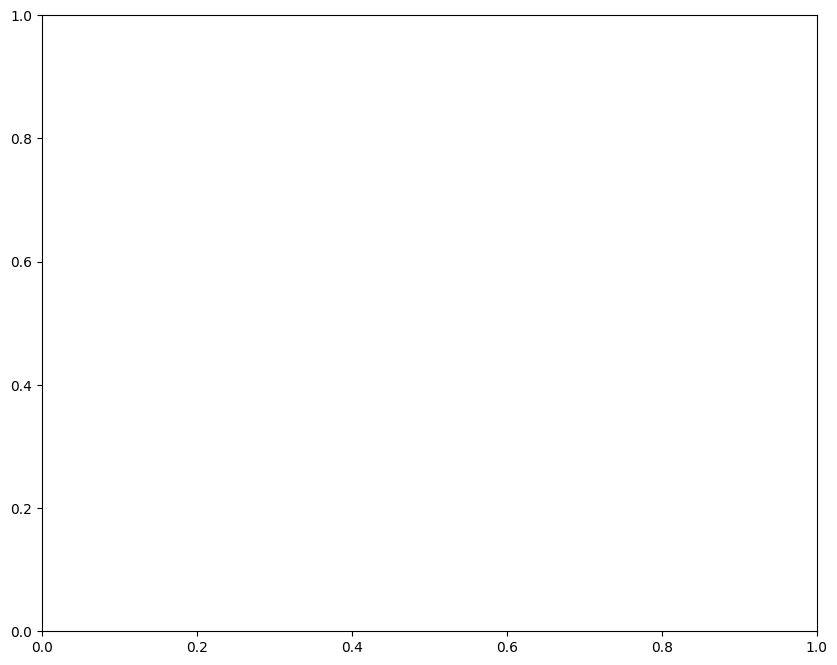

In [31]:

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

lightgbm 모델학습과 하이퍼 파라미터 튜닝
> 위의 xgboost 예제 코드를 기반으로 lightbgm으로 학습을 수행하고 roc-auc 를 측정

In [33]:

from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64],
          'max_depth': [128, 160],
          'min_child_samples': [60, 100],
          'subsample': [0.8, 1]}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 조합 검색
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

# 최적의 모델을 사용하여 ROC AUC 계산
best_lgbm_clf = gridcv.best_estimator_
lgbm_roc_score = roc_auc_score(y_test, best_lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

NameError: ignored

09. 분류 실습- 캐글 신용카드 사기 검출


>일반적으로 사기 검출이나 이상 검출과 같은 데이터 세트는 레이블 값이 극도로 불균형한 분포를 가지기 쉬움
>> 언더 샘플링과 오버 샘플링의 이해


*   레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬때 예측 성능의 문제가 발생할 수 있는데 이상 레이블값이 너무 작아서 발생함
*   극도로 불균형한 레이블값 분포로 인한 문제를 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요 -> 오버샘플링과 언더샘플링 방법이 존대하고 오버샘플링이 더 많이 사용됨


*   오버 샘플링은 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법






데이터 일차 가공 및 모델 학습 /예측/ 평가

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df= pd.read_csv('/content/creditcard.csv')
card_df.head(3)

#class는 레이블로서 0이 정상, 1이 사기

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0


In [35]:
from sklearn.model_selection import train_test_split
#인자로 입력받은 dataframe을 복사한뒤 time 만 삭제하고 복제된 dataframe 반환
def get_preprocessed_df(df=None):
  df_copy= df.copy()
  df_copy.drop('Time',axis=1,inplace=True)
  return df_copy


In [43]:

# get_train_test_dataset() : 내부에서 train_Test_split() 함수 호출하고 학습데이터세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만들어준다
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify= y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

ValueError: ignored

In [47]:
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

ValueError: ignored

In [48]:

# 레이블 값 비율을 백분율로 환산하여 잘 분할되었는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    96.096422
1     3.903578
Name: TARGET, dtype: float64
테스트 데이터 레이블 값 비율
0    95.830045
1     4.169955
Name: TARGET, dtype: float64


In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [51]:
# 로지스틱 회귀 분석 방법 사용
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[14570     0]
 [  634     0]]
정확도: 0.9583, 정밀도: 0.0000, 재현율: 0.0000,    F1: 0.0000, AUC:0.6072


In [52]:
# 인자로 사이킷런의 Estimator객체와 학습.테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [53]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


[LightGBM] [Info] Number of positive: 2374, number of negative: 58442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.299705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14308
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 251
오차 행렬
[[14492    78]
 [  612    22]]
정확도: 0.9546, 정밀도: 0.2200, 재현율: 0.0347,    F1: 0.0599, AUC:0.7971


데이터 분포도 변환 후 모델 학습/예측/평가
>왜곡된 분포도를 가지는 데이터를 재가공한 뒤 모델을 다시 테스트
>>
Amount 피처의 분포도 확인

<Axes: xlabel='Amount', ylabel='Density'>

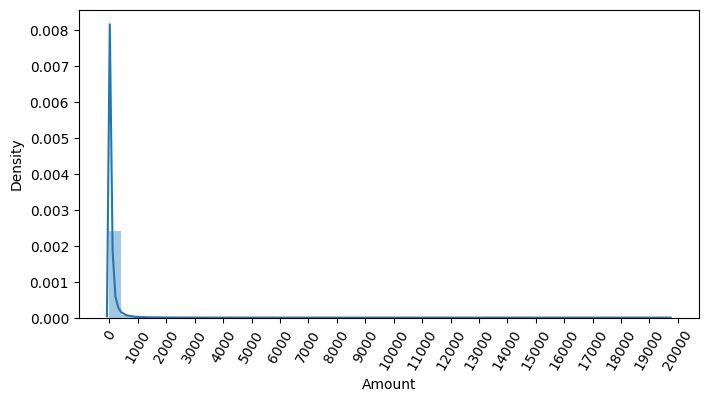

In [54]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])


In [55]:

from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [57]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

ValueError: ignored

In [ ]:

import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')